# Collaborative filter of movies

 ## Introduction
The main objetive of this notebook it is to create a collaboratvie filter capable of suggesting 5 movies given an user ID;

The dataset im using is [this](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) 9k movies with 100K ratings from [MovieLens](https://grouplens.org/datasets/movielens/)

Lesson 7 - Student 190011611

Github: ciro-c

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.imports import *
from fastai.collab import *
from fastai.tabular.all import *
np.set_printoptions(linewidth=130)

basePath = Path('../input/smallest/ml-latest-small')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading data

In [4]:
ratings = pd.read_csv(basePath/'ratings.csv')
ratings.columns = ['user','movie','rating','timestamp']
ratings.head()

,user,movie,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies = pd.read_csv(basePath/'movies.csv')
movies.rename(columns={'movieId': 'movie'}, inplace=True)
movies.head()

,movie,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Checking for missing values or null

In [67]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [82]:
movies.isna().sum()

movie     0
title     0
genres    0
dtype: int64

## Looking at the data more visualy

In [75]:
def crosstab(ratings, max_nan_user=590, max_nan_movie=5):
  # create a crosstab with user as row index, movie as column index, and ratings as cells
  # the aggfunc will copy the cross number, since there is no repetition

  ctdf = pd.crosstab(ratings.user, ratings.movie,values=ratings.rating, aggfunc='sum');

  # movies_null_cont_serie: count amount of nan for each column
  movies_null_cont_serie = ctdf.isnull().sum(axis = 0);

  # filter out th movies with less than 590 user rating
  ctdf = ctdf[movies_null_cont_serie[movies_null_cont_serie<=max_nan_user].index]

  # drop user with no rating for the movies that stayed in dataframe
  ctdf = ctdf.dropna(axis = 0, how = 'all')

  # drop user with no rating for the movies that stayed in dataframe
  user_null_cont_serie = ctdf.isnull().sum(axis = 1)
  ctdf = ctdf.loc[user_null_cont_serie[user_null_cont_serie<max_nan_movie].index]
  return ctdf

In [76]:
crosstab(ratings,max_nan_user=400)

movie,1,110,260,296,318,356,480,527,589,593,1196,2571,2959
user,,,,,,,,,,,,,
1,4.0,4.0,5.0,3.0,NaN,4.0,4.0,5.0,NaN,4.0,5.0,5.0,5.0
15,2.5,NaN,5.0,4.0,5.0,5.0,NaN,5.0,5.0,NaN,5.0,4.0,2.5
16,NaN,NaN,3.0,3.0,4.0,3.5,NaN,4.0,NaN,3.0,3.0,3.5,3.5
17,4.5,4.5,5.0,5.0,5.0,5.0,4.5,4.5,4.5,4.5,5.0,5.0,4.5
18,3.5,4.5,4.0,4.0,5.0,4.5,3.5,4.5,4.5,4.5,4.0,4.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,4.0,1.0,4.0,5.0,NaN,3.0,NaN,3.0,NaN,5.0,3.0,5.0,4.0
606,2.5,3.5,4.5,5.0,3.5,4.0,2.5,5.0,3.5,4.5,4.5,5.0,5.0
607,4.0,5.0,3.0,3.0,5.0,NaN,4.0,5.0,4.0,5.0,3.0,5.0,NaN


<Axes: >

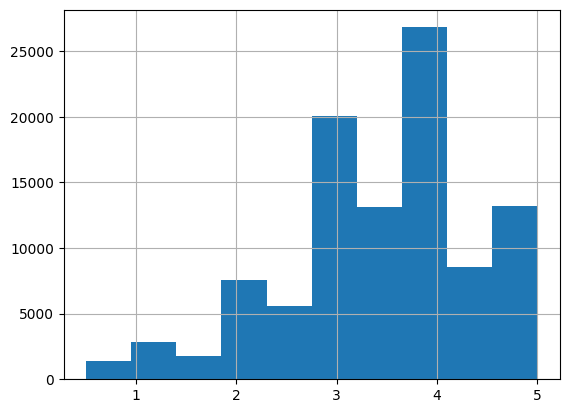

In [78]:
# Ratting distribuition
ratings['rating'].hist()

<Axes: >

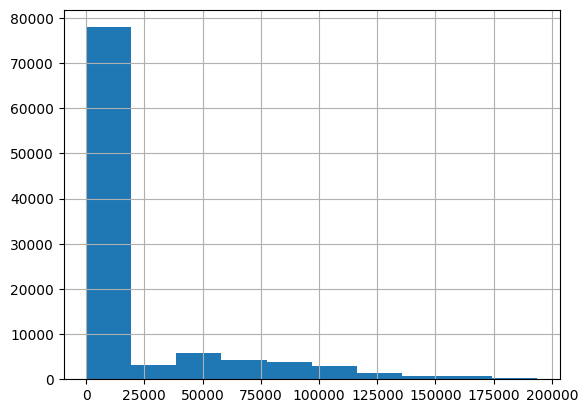

In [79]:
#Movies more avaliated
ratings['movie'].hist()

<Axes: >

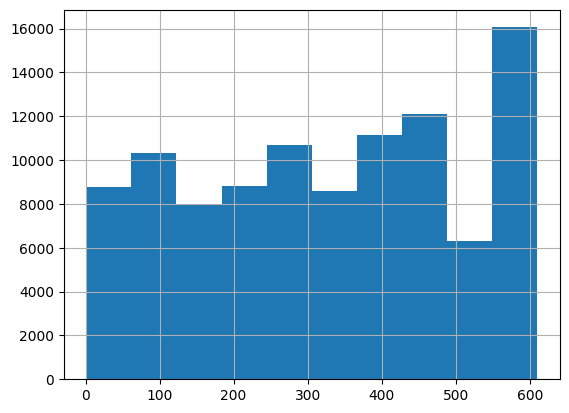

In [80]:
#Users with more avaliations
ratings['user'].hist()

## Generating our data frame

In [33]:
#Merging ratings with movies
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [7]:
dls = CollabDataLoaders.from_df(dls, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,82,Austin Powers in Goldmember (2002),3.5
1,610,Dracula Untold (2014),2.5
2,288,Sleepless in Seattle (1993),3.0
3,18,Hitchcock (2012),3.5
4,414,Heartbreakers (2001),3.0
5,610,Red Eye (2005),3.0
6,105,Hero (Ying xiong) (2002),4.0
7,184,Ant-Man (2015),4.0
8,387,Jacob's Ladder (1990),4.0
9,610,Ginger Snaps Back: The Beginning (2004),3.0


In [8]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

print(f'Number of users: {n_users}')
print(f'Number of movies: {n_movies}')
print(f'Number of factors: {n_factors}')

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

Number of users: 611
Number of movies: 9720
Number of factors: 5


## Manual filter with embebed


In [11]:
# Without bias
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.0)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [20]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.942091,0.917373,00:08
1,0.768045,0.822588,00:07
2,0.580255,0.787919,00:08
3,0.371970,0.780030,00:07
4,0.269120,0.782743,00:08


In [13]:
# With Bias
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [24]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.826503,0.783668,00:08
1,0.656562,0.713701,00:08
2,0.435626,0.738615,00:08
3,0.232609,0.751244,00:08
4,0.144794,0.756235,00:08


### With weigth reduction

In [21]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.954261,0.933114,00:08
1,0.814437,0.838114,00:07
2,0.689481,0.787772,00:07
3,0.547108,0.763962,00:07
4,0.457334,0.761096,00:08


In [25]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.832447,0.802497,00:08
1,0.686884,0.725939,00:08
2,0.544194,0.704810,00:08
3,0.398484,0.699823,00:08
4,0.304727,0.701435,00:08


## Filter with manual embebbed

In [26]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [27]:
# without weight reduction
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.792733,0.784415,00:09
1,0.676768,0.719841,00:08
2,0.440847,0.735441,00:09
3,0.228807,0.749038,00:09
4,0.147417,0.754014,00:08


In [31]:
# with weigth reduction
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.840035,0.798834,00:09
1,0.722829,0.728468,00:09
2,0.577870,0.708463,00:09
3,0.412303,0.700254,00:08
4,0.288608,0.701867,00:09


### How our model see the tittles

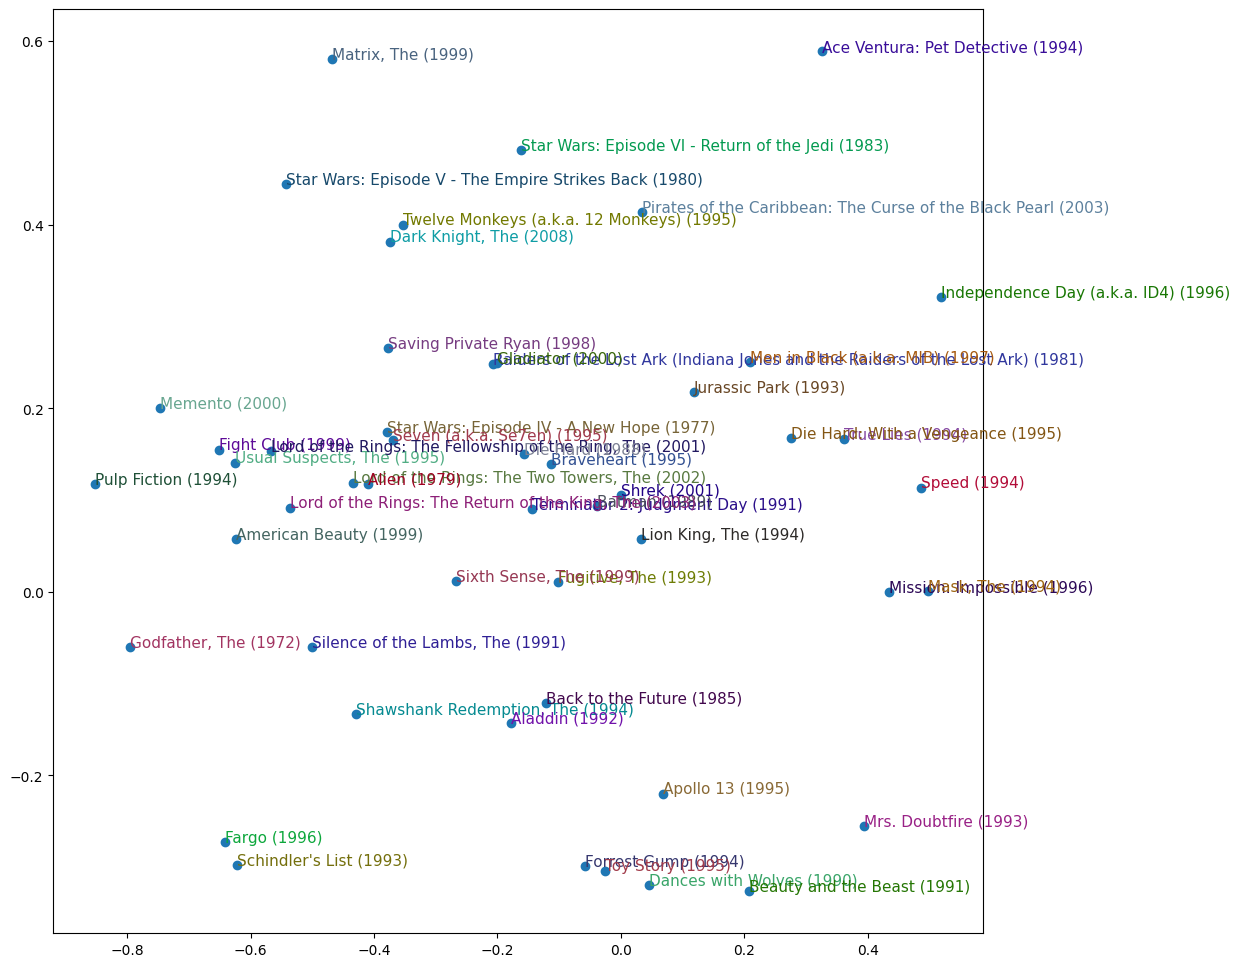

In [34]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Fastai filter


In [35]:
# With weight reduction
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.812967,0.796951,00:10
1,0.721498,0.724224,00:10
2,0.566116,0.704361,00:09
3,0.409114,0.699496,00:09
4,0.301564,0.701442,00:08


In [50]:
# Without wd
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.823758,0.784588,00:08
1,0.684848,0.713834,00:08
2,0.439336,0.730654,00:08
3,0.237833,0.741237,00:08
4,0.149077,0.746132,00:09


## Deeplearn Filter

In [37]:
embs = get_emb_sz(dls)
embs

[(611, 58), (9720, 274)]

In [38]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [40]:
model = CollabNN(*embs)

In [43]:
# with weight reduction
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.814296,0.782285,00:09
1,0.734292,0.738807,00:09
2,0.683244,0.728093,00:09
3,0.622602,0.728993,00:09
4,0.565724,0.746866,00:09


In [44]:
# without weight reduction
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.633269,0.744814,00:09
1,0.669655,0.753338,00:09
2,0.631727,0.743361,00:09
3,0.508550,0.755209,00:09
4,0.462794,0.778705,00:09


### With more layers


In [48]:
# With weight reduction
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.823101,0.816197,00:10
1,0.769781,0.758110,00:10
2,0.711319,0.731309,00:10
3,0.655977,0.721443,00:10
4,0.553752,0.733010,00:10


In [46]:
# Without weight reduction
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.816908,0.821227,00:10
1,0.762401,0.749648,00:10
2,0.674428,0.721301,00:10
3,0.586697,0.729669,00:10
4,0.540149,0.747832,00:10


## Looking at bias

Well get the bias from the learner of fastAi without the WD to look at the movies with the top 5 bias



In [55]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Forrest Gump (1994)',
 'Philadelphia Story, The (1940)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Good Will Hunting (1997)']

We can also look at the distance between movies, lets get the 5 nearest


In [62]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Shawshank Redemption, The (1994)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[:5]
dls.classes['title'][idx]

(#5) ['Shawshank Redemption, The (1994)','Lock, Stock & Two Smoking Barrels (1998)','Everest (1998)','More American Graffiti (1979)','White Christmas (1954)']

One thing to notice is that the movie with the most bias is not near the top 5 movies 

In [97]:
learn.model.u_weight.weight

Parameter containing:
tensor([[ 0.0060, -0.0088, -0.0122,  ..., -0.0169,  0.0046, -0.0101],
        [-0.2633, -0.2441,  0.2110,  ..., -0.1295,  0.0276, -0.2035],
        [ 0.2030,  0.1810,  0.0824,  ...,  0.1273, -0.0308, -0.2355],
        ...,
        [ 0.2731,  0.1849,  0.2580,  ...,  0.1480,  0.1291, -0.3626],
        [-0.0748,  0.1224,  0.1421,  ..., -0.1605,  0.1735, -0.3163],
        [-0.3096,  0.1272, -0.0352,  ..., -0.0239, -0.0569, -0.4385]],
       device='cuda:0', requires_grad=True)

## How to predict

This code was teste with fastAi model. The others could not work.

In [106]:
def top_predictions(user, recommendations = 5):
    items = pd.Series(learn.dls.classes['title']).unique()
    
    clas_items = ratings.loc[(ratings['user'] == user) & (ratings['rating'] > 0), 'title']
    
    no_clas_items = np.setdiff1d(items, clas_items)

    df = pd.DataFrame({'user': [user]*len(no_clas_items), 'title': no_clas_items})
    
    preds,_ = learn.get_preds(dl=learn.dls.test_dl(df))
    
    df['prediction'] = preds.numpy()
    
    top_5 = df.nlargest(recommendations, 'prediction')
    
    return '\n'.join(top_5['title'].tolist())

In [107]:
top_predictions(5)

'Wizard of Oz, The (1939)\nChristmas Story, A (1983)\nRaiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)\nManchurian Candidate, The (1962)\nBonnie and Clyde (1967)'

## Exporting model

You can choose one of the learners of this notebook to export. In this example well use the fastAI without WD to export

In [63]:
learn.export('clayFilter.pkl')